In [1]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Read data

In [2]:
import pickle
# import xgboost
# import s3fs

In [3]:
# # Save model to bucket
# s3 = s3fs.S3FileSystem(anon=False, 
#                        key='',
#                        secret='')
# # Use 'w' for py3, 'wb' for py2
# with s3.open('bsa-correlation-one/models/xgboost_cellphones_C.pkl','rb') as f:
#     # END
#     model = pickle.load(f)

In [4]:
def base_cost(offer):
    return 0.8 * offer

In [5]:
with open('./lr_cellphone_C.pkl','rb') as f:
#     # END
    model = pickle.load(f)

/home/renato/.pyenv/versions/miniconda3-4.3.30/envs/main/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/renato/.pyenv/versions/miniconda3-4.3.30/envs/main/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
data = pd.read_csv('./cellphones/cellphonedata.csv')
df = data[data.price_category == 'C'].copy().reset_index(drop=True)
df.drop(columns = ['ds','price_category'],inplace=True)
df['base_cost'] = df.offer.apply(lambda x: base_cost(x))

baseline_prices = df['olist_price'].values

In [7]:
df.columns

Index(['year', 'month', 'dayofweek', 'day', 'offer', 'olist_price',
       'freight_value', 'competition_price', 'stock', 'black_friday',
       'carnival', 'christmas', 'friday', 'mothers_day', 'new_year', 'others',
       'valentines', 'y', 'base_cost'],
      dtype='object')

In [8]:
def demand_baseline(model, df_row, olist_price):
    
    year = df_row.year
    month = df_row.month
    dayofweek = df_row.dayofweek
    day = df_row.day
    olist_price = df_row.olist_price
    freight_value = df_row.freight_value
    competition_price = df_row.competition_price
    stock = df_row.stock
    black_friday = df_row.black_friday
    carnival = df_row.carnival
    christmas = df_row.christmas
    friday = df_row.friday
    mothers_day = df_row.mothers_day
    new_year = df_row.new_year
    others = df_row.others
    valentines = df_row.valentines

    X = np.array([year, month, dayofweek, day, olist_price, freight_value,
                 competition_price, stock, black_friday, carnival, christmas,
                 friday, mothers_day, new_year, others, valentines]).reshape(1,-1)
    
    #X = xgboost.DMatrix(X)
                 
    orders = model.predict(X)
    
    return max(orders[0],0)

In [9]:
y_pred = []
for row in df.itertuples():
    y_pred.append(demand_baseline(model, row, 0)) 

In [10]:
baseline = (df.olist_price + df.freight_value - df['base_cost']) * y_pred

In [11]:
sum(baseline)

914367.8923021916

In [12]:
sum(df['y'])
#sum(y_pred)

4120.0

In [13]:
data = pd.read_csv('./cellphones/cellphonedata.csv')
data = data[data.price_category == 'C'].copy().reset_index(drop=True) 
df = data[data.price_category == 'C'].copy().reset_index(drop=True)
df.drop(columns = ['ds','price_category'],inplace=True)
df['base_cost'] = df.offer.apply(lambda x: base_cost(x))

# cols = df.columns
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# normalized = scaler.fit_transform(df)

# df = pd.DataFrame(normalized, columns=cols)

df.drop(columns = ['offer'],inplace=True)

# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# X, y  = df.drop(columns=['base_cost', 'y']).values, df['y'].values
# model = model.fit(X, y)

df.drop(columns=['olist_price','y'], inplace=True)

print(model.coef_)
print(model.intercept_)

df.tail()

[ 1.81950576e+00  2.71229539e-01 -2.10499856e-01 -6.07342232e-02
 -1.46755260e-02 -2.58422221e-01  3.73049448e-02  5.49076446e-04
  1.41589235e+01 -2.79617226e+00 -3.78379614e+00  2.31820611e+00
  9.07847585e-01 -2.85046846e+00 -4.74860599e+00  6.81994266e+00]
-3684.712898495253


,year,month,dayofweek,day,freight_value,competition_price,stock,black_friday,carnival,christmas,friday,mothers_day,new_year,others,valentines,base_cost
971,2020,2,0,24,26.165168,982.949133,7563.0,0,1,0,0,0,0,0,0,747.528000
972,2020,2,1,25,26.522039,988.725646,7557.0,0,1,0,0,0,0,0,0,751.569143
973,2020,2,2,26,24.607285,994.662702,7545.0,0,0,0,0,0,0,0,0,747.531678
974,2020,2,3,27,22.893772,1007.349470,7454.0,0,0,0,0,0,0,0,0,743.240006
975,2020,2,4,28,31.916422,1095.717500,127.0,0,0,0,0,0,0,0,0,749.329333


### Demand Simulator

In [14]:
def predict_demand(model, df_row, olist_price):
    
    year = df_row.year
    month = df_row.month
    dayofweek = df_row.dayofweek
    day = df_row.day
    olist_price = olist_price
    freight_value = df_row.freight_value
    competition_price = df_row.competition_price
    stock = df_row.stock
    black_friday = df_row.black_friday
    carnival = df_row.carnival
    christmas = df_row.christmas
    friday = df_row.friday
    mothers_day = df_row.mothers_day
    new_year = df_row.new_year
    others = df_row.others
    valentines = df_row.valentines

    X = np.array([year, month, dayofweek, day, olist_price, freight_value,
                 competition_price, stock, black_friday, carnival, christmas,
                 friday, mothers_day, new_year, others, valentines]).reshape(1,-1)
    
    #X = xgboost.DMatrix(X)
                 
    orders = model.predict(X)
    
    return max(orders[0],0)

In [15]:
predict_demand(model, df.iloc[-1], 800)

9.645716631745927

### Environment Real Data

In [16]:
class Environment:
    
    def __init__(self, model, df):
        
        self.model = model
        self.data = df
        self.N = len(self.data) - 1
        self.reset()
        
        
    def reset(self):
        self.t = 0
        self.done = False
        self.orders = 0
        self.olist_price = 0
        self.profits = 0
        return [self.olist_price, self.orders] + self.data.iloc[self.t].tolist() 
    
    def step(self, act):       
        
        # act = 0: stay, 1: raise, 2: lower
        if act == 0:
            self.olist_price = self.data['base_cost'][self.t] * 1.05
        elif act == 1:
            self.olist_price = self.data['base_cost'][self.t] * 1.075
        elif act == 2:
            self.olist_price = self.data['base_cost'][self.t] * 1.10
        elif act == 3:
            self.olist_price = self.data['base_cost'][self.t] * 1.125
        elif act == 4:
            self.olist_price = self.data['base_cost'][self.t] * 1.15
        elif act == 5:
            self.olist_price = self.data['base_cost'][self.t] * 1.175
        elif act == 6:
            self.olist_price = self.data['base_cost'][self.t] * 1.20
        elif act == 7:
            self.olist_price = self.data['base_cost'][self.t] * 1.225
        elif act == 8:
            self.olist_price = self.data['base_cost'][self.t] * 1.25
        elif act == 9:
            self.olist_price = self.data['base_cost'][self.t] * 1.275

        # Calculate demand
        self.orders = predict_demand(self.model, self.data.iloc[self.t], self.olist_price)        

        reward = (self.olist_price + self.data['freight_value'][self.t] - self.data['base_cost'][self.t])*self.orders
        self.profits += reward

        # set next time
        self.t += 1
        
        if (self.t == self.N):
            self.done=True

        return [self.olist_price, self.orders] + self.data.iloc[self.t].tolist(), reward, self.done # obs, reward, done 

In [17]:
env = Environment(model,df)
env.reset()

[0,
 0,
 2017.0,
 6.0,
 4.0,
 30.0,
 25.73,
 931.1842857142856,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 744.9474285714285]

## NN architecture

In [18]:
#def train_dqn(env):

#whats the return?
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
#         self.fc_val = nn.Sequential(
#             nn.Linear(obs_len, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, actions_n)
#             # needs softmax?
#         )
        
        self.fc_val = nn.Sequential(
            nn.BatchNorm1d(num_features=obs_len),
            nn.Linear(obs_len, hidden_size),            
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, actions_n),
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)
            
            

## Parameters

In [19]:
np.random.seed(36)
torch.manual_seed(36)

hidden_size = 50
input_size = 2 + df.shape[1]
output_size = 10 #5
LR = 0.001

epoch_num = 2
step_max = len(env.data) - 1
memory_size = 320 # 200
batch_size = 32
gamma = 0.9 # 0.97

epsilon = 1.0
epsilon_decrease = 1e-4
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 30 #20
show_log_freq = 5

## Training

In [20]:
memory = []
total_step = 0
total_rewards = []
total_losses = []

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Q = Q_Network(input_size, hidden_size, output_size).to(device=device)

Q_ast = copy.deepcopy(Q)

loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

start = time.time()
for epoch in range(epoch_num):

    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:

        # select act

        pact = np.random.randint(10)
        if np.random.rand() > epsilon:
            #whats the return value?
            Q.eval()
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
            pact = np.argmax(pact.data.cpu())
            pact = pact.numpy()
        
        # act
        obs, reward, done = env.step(pact)

        # add memory
        
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)
                    
                    Q.train()
                    q = Q(torch.from_numpy(b_pobs).to(device=device))
                    q_ = Q_ast(torch.from_numpy(b_obs).to(device=device))
                    maxq = np.max(q_.data.cpu().numpy(), axis=1)
                    target = copy.deepcopy(q.data)
                    #import pdb; pdb.set_trace()

                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        #if (epoch+1) % show_log_freq == 0:
        if done or step == step_max:  
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
#return Q, total_losses, total_rewards

1	0.954500000000005	656	512114.29901116266	47360788.10136719	6.228331565856934
2	0.8570000000000157	1631	446883.31459500437	54674655.80673828	6.2017822265625


In [21]:
df.shape

(976, 16)

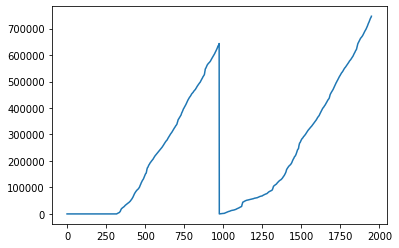

In [22]:
plt.plot(total_rewards[-30000:])

## Testing

In [23]:
test_env = Environment(model,df)
test_acts=[]
test_rewards = []
orders = []
o_prices = []
pobs = test_env.reset()
profits_2 = 0
pact_history = []
done = False
while not done:
    Q.eval()
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
    pact = np.argmax(pact.data.cpu())
    pact_history.append(pact)
    test_acts.append(pact.item())
    
    obs, reward, done = test_env.step(pact.numpy())
    orders.append(obs[1])
    o_prices.append(obs[0])
    test_rewards.append(reward)
    profits_2 += reward
    pobs = obs

test_profits = test_env.profits

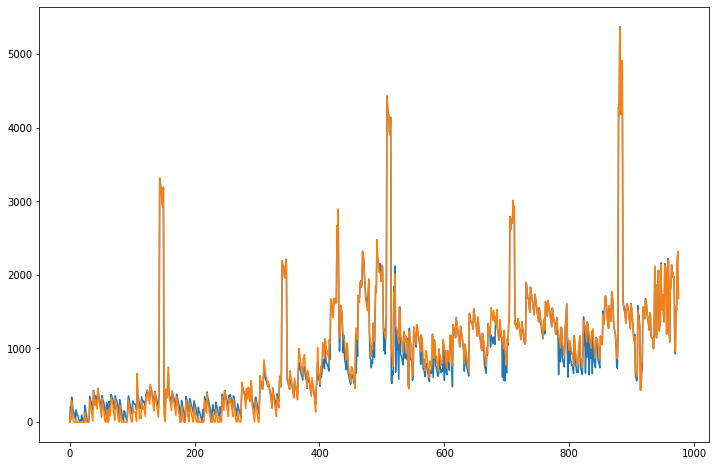

In [24]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards)
plt.plot(baseline)

In [25]:
test_profits

901297.1113531851

In [26]:
sum(baseline)

914367.8923021916

### Save results

In [27]:
o_prices #975
orders # 975
test_acts # 975
test_rewards # 975

results = df.iloc[:-1].copy()

results['baseline_prices'] = baseline_prices[:-1]
results['baseline_orders'] = y_pred[:-1]
results['baseline_rewards'] = baseline[:-1]
results['rl_prices'] = o_prices
results['rl_orders'] = orders
results['rl_actions'] = test_acts
results['rl_rewards'] = test_rewards
results['group'] = 'electronics'
results['type'] = 'cellphones'
results['price_range'] = 'C'

In [28]:
results.head()

,year,month,dayofweek,day,freight_value,competition_price,stock,black_friday,carnival,christmas,...,baseline_prices,baseline_orders,baseline_rewards,rl_prices,rl_orders,rl_actions,rl_rewards,group,type,price_range
0,2017,6,4,30,25.73,931.184286,0.0,0,0,0,...,931.184286,0.000000,0.000000,856.689543,0.000000,4,0.000000,electronics,cellphones,C
1,2017,7,5,1,25.73,931.184286,0.0,0,0,0,...,931.184286,0.438547,92.957337,856.689543,1.531796,4,210.579248,electronics,cellphones,C
2,2017,7,6,2,25.73,931.184286,0.0,0,0,0,...,931.184286,0.167312,35.464701,856.689543,1.260562,4,173.292126,electronics,cellphones,C
3,2017,7,0,3,25.73,931.184286,0.0,0,0,0,...,931.184286,1.369577,290.305016,856.689543,2.462827,4,338.570025,electronics,cellphones,C
4,2017,7,1,4,25.73,931.184286,0.0,0,0,0,...,931.184286,1.098343,232.812381,856.689543,2.191593,4,301.282903,electronics,cellphones,C


## Random Seed

In [29]:
stop = False
seeds = 1
# Params
while stop == False:
    
    np.random.seed(seeds)
    torch.manual_seed(seeds)

    env = Environment(model,df)
    env.reset()
    
    hidden_size = 30
    input_size = 2 + df.shape[1]
    output_size = 10 #5
    LR = 0.001

    epoch_num = 2
    step_max = len(env.data) - 1
    memory_size = 320 # 200
    batch_size = 32
    gamma = 0.95 # 0.97

    epsilon = 1.0
    epsilon_decrease = 1e-4
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 30 #20
    show_log_freq = 5

    # Training

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    Q = Q_Network(input_size, hidden_size, output_size).to(device=device)

    Q_ast = copy.deepcopy(Q)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(list(Q.parameters()), lr=LR)

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act

            pact = np.random.randint(10)
            if np.random.rand() > epsilon:
                #whats the return value?
                Q.eval()
                pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
                pact = np.argmax(pact.data.cpu())
                pact = pact.numpy()

            # act
            obs, reward, done = env.step(pact)

            # add memory

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        Q.train()
                        q = Q(torch.from_numpy(b_pobs).to(device=device))
                        q_ = Q_ast(torch.from_numpy(b_obs).to(device=device))
                        maxq = np.max(q_.data.cpu().numpy(), axis=1)
                        target = copy.deepcopy(q.data)
                        #import pdb; pdb.set_trace()

                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.zero_grad()
                        loss = loss_function(q, target)
                        total_loss += loss.data.item()
                        loss.backward()
                        optimizer.step()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

                # epsilon
                if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                    epsilon -= epsilon_decrease

                # next step
                total_reward += reward
                pobs = obs
                step += 1
                total_step += 1

            total_rewards.append(total_reward)
            total_losses.append(total_loss)

            #if (epoch+1) % show_log_freq == 0:
            if done or step == step_max:  
                log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
                log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
                elapsed_time = time.time()-start
                print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
                start = time.time()


#     test_env = Environment(model,df)
#     test_acts=[]
#     test_rewards = []
#     pobs = test_env.reset()
#     profits_2 = 0
#     pact_history = []
#     done = False
#     while not done:
#         Q.eval()
#         pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
#         pact = np.argmax(pact.data.cpu())
#         pact_history.append(pact)
#         test_acts.append(pact.item())

#         obs, reward, done = test_env.step(pact.numpy())
#         test_rewards.append(reward)
#         profits_2 += reward
#         pobs = obs

#     test_profits = test_env.profits
    
    test_env = Environment(model,df)
    test_acts=[]
    test_rewards = []
    orders = []
    o_prices = []
    pobs = test_env.reset()
    profits_2 = 0
    pact_history = []
    done = False
    while not done:
        Q.eval()
        pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
        pact = np.argmax(pact.data.cpu())
        pact_history.append(pact)
        test_acts.append(pact.item())

        obs, reward, done = test_env.step(pact.numpy())
        orders.append(obs[1])
        o_prices.append(obs[0])
        test_rewards.append(reward)
        profits_2 += reward
        pobs = obs

    test_profits = test_env.profits
    print(test_profits)
    
    if test_profits > sum(baseline):
        print('FINISHED!!!!!!!!!!')
        print(seeds)
        stop = True
    else:
        seeds += 1

1	0.954500000000005	656	517832.46945530956	48736289.9125	4.49300742149353
2	0.8570000000000157	1631	463171.1750112449	56792553.92089844	6.214609622955322
944460.8516773758
FINISHED!!!!!!!!!!
1


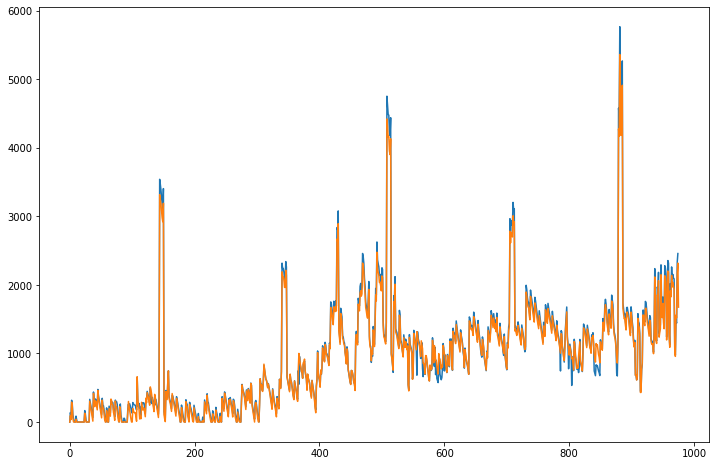

In [30]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards)
plt.plot(baseline)

In [31]:
results = df.iloc[:-1].copy()

results['baseline_prices'] = baseline_prices[:-1]
results['baseline_orders'] = y_pred[:-1]
results['baseline_rewards'] = baseline[:-1]
results['rl_prices'] = o_prices
results['rl_orders'] = orders
results['rl_actions'] = test_acts
results['rl_rewards'] = test_rewards
results['group'] = 'electronics'
results['type'] = 'cellphones'
results['price_range'] = 'C'

In [32]:
results.to_csv('./cellphones/cellphones_final_results.csv', index=False)

In [33]:
results.rl_rewards.sum() / results.baseline_rewards.sum()

1.0348069463688465

In [34]:
a = results[(results.year==2020)& (results.month==1)]['rl_rewards'].sum()
b = results[(results.year==2020)& (results.month==1)]['baseline_rewards'].sum()

In [35]:
a/b

1.0439892464655691

In [36]:
torch.save(Q.state_dict(), './Q_state.torch')

In [37]:
df.to_csv('./df.csv', index=False)

In [45]:
print('Jan/2020:')
month = 1
rb = results[(results['year'] == 2020) & (results['month'] == month)]['baseline_rewards'].sum()
rrl = results[(results['year'] == 2020) & (results['month'] == month)]['rl_rewards'].sum()
print(f'Baseline: {rb} RL: {rrl}')
print('Feb/2020:')
month = 2
rb = results[(results['year'] == 2020) & (results['month'] == month)]['baseline_rewards'].sum()
rrl = results[(results['year'] == 2020) & (results['month'] == month)]['rl_rewards'].sum()
print(f'Baseline: {rb} RL: {rrl}')

Jan/2020:
Baseline: 44407.53046942968 RL: 46360.98427217669
Feb/2020:
Baseline: 46673.004029364194 RL: 48907.051479988484
